In [1]:
# default_exp analyses

In [1]:
#| code-summary: -- load dependencies and data and select parameters
#| output: asis

from compmemlearn.analyses import recall_by_all_study_positions
import os.path

analysis_overview = """
# The Lag-Contiguity Effect
The lag-contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. In addition, episodic associations appear to be asymmetrical, favoring retrieval of items in the forward order.

The lag-CRP analysis measures the lag-contiguity effect in free recall data by tracking the conditional probability of retrieving an unrecalled item as a function of its lag in the study list from the last recalled item. For example, if a research participant recalls the third item presented in a list and then the fourth, the corresponding lag is +1. If a participant instead recalls the first item after recalling the third item, the measured lag is -2. The ratio of actual divided by possible lag transitions across a dataset over a range of lag values tends to identify a lag-contiguity effect.
"""

analysis_tag = 'crp'
data_paths = ["../../data/CDCATBEH.csv", "../../data/LohnasKahana2014.csv", "../../data/HowardKahana2005.csv"]
trial_queries = [
    ["list_type == 'light'", "list_type == 'heavy'"], 
    ["condition == 1", "condition == 2", "condition == 3", "condition == 4"], 
    ["condition == 0", "condition == 1", "condition == 2"]
    ]
query_labels = trial_queries

show_figure = True
regenerate_figure = True
section_tags = ["CDCATBEH", "LohnasKahana2014", "HowardKahana2005"]
figures_path = "figures/"
figure_caption = """The lag-contiguity effect measured as a function of list length using data from @{}."""

print(analysis_overview)


# The Lag-Contiguity Effect
The lag-contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. In addition, episodic associations appear to be asymmetrical, favoring retrieval of items in the forward order.

The lag-CRP analysis measures the lag-contiguity effect in free recall data by tracking the conditional probability of retrieving an unrecalled item as a function of its lag in the study list from the last recalled item. For example, if a research participant recalls the third item presented in a list and then the fourth, the corresponding lag is +1. If a participant instead recalls the first item after recalling the third item, the measured lag is -2. The ratio of actual divided by possible lag transitions across a dataset over a range of lag values tends to identify a lag-contiguity effect.



In [2]:
# export
#| code-summary: -- specify lag-contiguity effect analysis code

from compmemlearn.datasets import events_metadata, generate_trial_mask
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns
import pandas as pd
import numpy as np

@njit(fastmath=True, nogil=True)
def fast_crp(trials, item_count):
    
    lag_range = item_count - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1)
    
    # compute actual serial lag b/t recalls
    actual_lags = trials[:, 1:] - trials[:, :-1]
    actual_lags += lag_range
    
    # tabulate bin totals for actual and possible lags
    for i in range(len(trials)):
        possible_items = np.arange(item_count) + 1
        previous_item = 0
        
        for recall_index in range(terminus[i]):
            
            # track possible and actual lags
            if recall_index > 0:
                total_actual_lags[actual_lags[i, recall_index-1]] += 1
                
                # exploit equivalence b/t item index and study position to track possible lags
                possible_lags = possible_items - previous_item 
                possible_lags += lag_range
                total_possible_lags[possible_lags] += 1
                
            # update pool of possible items to exclude recalled item
            previous_item = trials[i, recall_index]
            possible_items = possible_items[possible_items != previous_item]
    
    # small correction to avoid nans
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

In [3]:
# export
#| code-summary: -- specify lag-contiguity effect analysis code

@njit(nogil=True)
def flex_mixed_crp(trials, presentations):
    
    list_length = len(presentations[0])
    max_repeats = int(np.ceil(np.max(np.bincount(
        presentations.ravel())/len(presentations))))
    lag_range = list_length - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    recall_by_study_position = recall_by_all_study_positions(trials, presentations, max_repeats)
    
    for trial_index in range(len(trials)):
        
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, max_repeats), dtype=np.int32)
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            pos = np.nonzero(presentations[trial_index] == item)[0] + 1
            possible_positions[item, :len(pos)] = pos
            
        for recall_index in range(terminus[trial_index]):
            
            current_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            
            # track possible and actual lags
            if recall_index > 0:
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                current_index = np.nonzero(possible_items==current_item)[0]
                possible_lags = np.zeros((len(recall_by_study_position) ** 2, len(possible_items)), dtype=np.int32)

                index = 0
                for x in range(len(recall_by_study_position)):
                    for y in range(len(recall_by_study_position)):
                        if possible_positions[previous_item, y] > 0:
                        
                            possible_lags[index] = possible_positions[
                                possible_items, x] - possible_positions[previous_item, y]
                            
                            # if tracked position is 0, then we don't actually want to count it in our lags
                            possible_lags[index][possible_positions[possible_items, x] == 0] = 0
                        
                        index += 1
                possible_lags += lag_range

                total_actual_lags[possible_lags[:, current_index].flatten()] += 1
                total_possible_lags[possible_lags.flatten()] += 1
                        

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]
                    
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[lag_range] = 0
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

In [11]:
# export
#| code-summary: -- specify lag-contiguity effect analysis code

def plot_crp(data, trial_query, contrast_name=None, labels=None, axis=None, max_lag=5, handle_repetitions=None, mask=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)[:3]
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        lag_interval = np.arange(-max_lag, max_lag+1)
        lag_range = list_length -1
        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            if mask is None:
                if handle_repetitions is None:
                    handle_repetitions = not (presentations == np.arange(list_length)).all()
                
                if not handle_repetitions:
                    res = fast_crp(trials[subject_specific_trial_mask], list_length)
                else:
                    res = flex_mixed_crp(
                        trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask])
            else:
                res = masked_crp(trials[subject_specific_trial_mask], list_length, mask)

            res[lag_range] = np.nan
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "lag": lag_interval,
                    "prob": res[lag_range-max_lag:lag_range+max_lag+1],
                    contrast_name: labels[data_index],
                    "positive": lag_interval > 0,
                }
            ))

    result = pd.concat(result).reset_index()
    sns.lineplot(
        ax=axis, data=result, x='lag', y='prob', err_style='bars', hue=contrast_name, legend=False, style="positive", dashes=False)
    
    axis.set(xlabel='Lag', ylabel='Conditional Resp. Prob.')
    axis.set_xticks(np.arange(-max_lag, max_lag+1, 1))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis, result

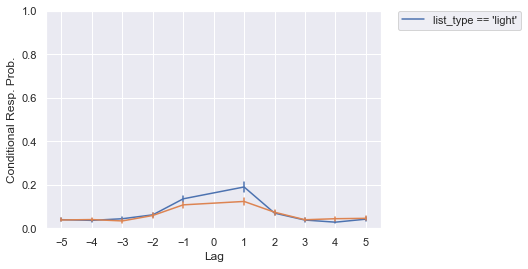

In [12]:
#| code-summary: -- perform and visualize crp using pre-defined parameters
#| output: asis

sns.set(style='darkgrid')
import warnings
warnings.filterwarnings(action='once')

for i in range(len(data_paths)):
    section_tag = section_tags[i]
    trial_query = trial_queries[i]
    query_label = query_labels[i]
    data_path = data_paths[i]

    if regenerate_figure or show_figure:
        ax = None
        for query in trial_query:

            events = pd.read_csv(data_path)
            trials, list_lengths, presentations = events_metadata(events)[:3]
            ax = plot_crp([events], query, labels=[query], axis=ax)[0]

        ax.legend(handles=ax.lines[::4], labels=query_label, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        if regenerate_figure:
            plt.savefig(
                figures_path+f'{section_tag}_{analysis_tag}.pdf', bbox_inches="tight")
                
        if show_figure:
            plt.show()
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");
        plt.close()

    else:
        if not os.path.isfile(f'{figures_path}{section_tag}_{analysis_tag}.pdf'):
            print(
                f'Figure not found at {figures_path}{section_tag}_{analysis_tag}.pdf. Run with regenerate_figure=True to generate.')
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");
    break

## Variation: TCE by Serial Position

In [30]:
# export
#| code-summary: -- specify masked lag-contiguity effect analysis code

from compmemlearn.datasets import events_metadata, generate_trial_mask
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns
import pandas as pd
import numpy as np

@njit(fastmath=True, nogil=True)
def masked_crp(trials, item_count, mask):
    
    lag_range = item_count - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1)
    
    # compute actual serial lag b/t recalls
    actual_lags = trials[:, 1:] - trials[:, :-1]
    actual_lags += lag_range
    
    # tabulate bin totals for actual and possible lags
    for i in range(len(trials)):
        possible_items = np.arange(item_count) + 1
        previous_item = 0
        
        for recall_index in range(terminus[i]):
            
            # track possible and actual lags
            if recall_index > 0 and mask[i, recall_index-1]:
                total_actual_lags[actual_lags[i, recall_index-1]] += 1
                
                # exploit equivalence b/t item index and study position to track possible lags
                possible_lags = possible_items - previous_item 
                possible_lags += lag_range
                total_possible_lags[possible_lags] += 1
                
            # update pool of possible items to exclude recalled item
            previous_item = trials[i, recall_index]
            possible_items = possible_items[possible_items != previous_item]
    
    # small correction to avoid nans
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

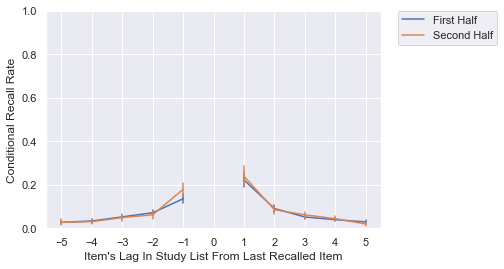

In [51]:
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings(action='once')

#section_tag = 'HealyKahana2014'
query = 'task == -1'
data_path = "../../data/HealyKahana2014.csv"
query = 'list_type == "heavy"'
data_path = "../../data/CDCATBEH.csv"
query = 'condition == 1'
data_path = "../../data/LohnasKahana2014.csv"

ax = None

events = pd.read_csv(data_path)
trials = events_metadata(events)[:1][0]
lower_mask = np.logical_and(trials[0] < int(np.max(trials[0])/2), trials[0] > 0)
upper_mask = trials[0] > int(np.max(trials[0])/2)
ax = plot_crp([events], query, labels=['First Half'], axis=ax, mask=lower_mask)[0]
ax = plot_crp([events], query, labels=['Second Half'], axis=ax, mask=upper_mask)[0]
ax.legend(handles=ax.lines[::4], labels=['First Half', 'Second Half'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [43]:
trials[0][0]

array([15, 16,  9, 13, 14,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [47]:
lower_mask[0]

array([False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False])